# IP AbuseScore

This is a jupyter notebook that calculates ip abusescores based on publicly available threat intelligence feeds.

## Prepare Environment

In [159]:
!pip install pandas maxminddb python-dotenv geopandas matplotlib mapclassify pycountry ipykernel

In [160]:
from dotenv import load_dotenv
load_dotenv()

import logging
logger = logging.getLogger()

## Utilities

In [161]:
def download_file_as(url, filepath, force_download=False):
    from os.path import exists, dirname
    from urllib.request import urlretrieve
    from pathlib import Path

    Path(dirname(filepath)).mkdir(parents=True, exist_ok=True)

    if exists(filepath) and not force_download:
        return
    
    urlretrieve(url, filepath)

In [162]:
available_lists = []

LIST_DIRECTORY = 'data'

def download_list_as(url, filename, force_download=False):
    from os.path import join

    filepath = join(LIST_DIRECTORY, filename)

    available_lists.append(filename)

    download_file_as(url, filepath, force_download)

In [163]:
import pandas as pd

def load_list(filename):
    from os.path import join

    with open(join(LIST_DIRECTORY, filename), 'r') as file:
        lines = [line.strip() for line in file if not line.startswith('#')]

    df = pd.DataFrame(lines, columns=['ip'])

    print(f"Loaded {filename} containing {len(df)}")

    return df

## Import Public Threat Intelligence Feeds

In [164]:
# Blocklist from https://greensnow.co/
download_list_as('https://blocklist.greensnow.co/greensnow.txt', 'greensnow_co.txt')

# Blocklist from https://github.com/borestad/blocklist-abuseipdb
download_list_as('https://raw.githubusercontent.com/borestad/blocklist-abuseipdb/main/abuseipdb-s100-30d.ipv4', 'abuseipdb_30d_blocklist.txt')

# Blocklist from https://www.blocklist.de/
download_list_as('https://www.blocklist.de/downloads/export-ips_all.txt', 'blocklist_de.txt')

# Blocklist from http://cinsscore.com/
download_list_as('http://cinsscore.com/list/ci-badguys.txt', 'cinsscore_com.txt')

# Blocklist from https://github.com/stamparm/ipsum (level 3)
download_list_as('https://raw.githubusercontent.com/stamparm/ipsum/master/levels/3.txt', 'ipsum_lv3.txt')

# Blocklist from http://doc.emergingthreats.net/bin/view/Main/CompromisedHost (https://opendbl.net/)
#download_list_as('https://opendbl.net/lists/etknown.list', 'emerginthreats.txt') # too small

# Blocklist from http://www.talosintelligence.com/ (https://opendbl.net/)
#download_list_as('https://opendbl.net/lists/talos.list', 'talos.txt') # too small

In [165]:
print(f"We have {len(available_lists)} lists available!")

We have 5 lists available!


## Extend and Transform lists

In [166]:
import maxminddb
import os

IPINFO_FILEPATH = 'data/country_asn.mmdb'

download_file_as(f"https://ipinfo.io/data/free/country_asn.mmdb?token={os.environ.get('IPINFO_KEY')}", IPINFO_FILEPATH)

ipinfo = maxminddb.open_database(IPINFO_FILEPATH)

In [167]:
import pycountry
import ipaddress

def add_ipinfo_data(ip):
    try:
        info = ipinfo.get(ip)
    except ValueError:
        logger.error(f"Invalid ip {ip}")
        info = {'country': None, 'continent': None, 'asn': None}

    if info is None:
        logger.warning(f"Empty ipinfo data for {ip}")
        info = {'country': None, 'continent': None, 'asn': None}

    try:
        return pd.Series({'country': info['country'], 'continent': info['continent'], 'asn': info['asn']})
    except TypeError:
        logger.error(f"Failed to build result for {ip} (ipinfo={info})")

def convert_alpha2_to_alpha3(alpha2):
    try:
        return str(pycountry.countries.get(alpha_2=alpha2).alpha_3)
    except LookupError:
        return None
    
def ip_to_ipaddress(ip):
    return ipaddress.ip_address(ip)

def ip_to_ipversion(ip):
    return 'IPv4' if isinstance(ip, ipaddress.IPv4Address) else 'IPv6'

df_lists = []

for alist in available_lists:
    df = load_list(alist)

    df[['source']] = alist

    df_lists.append(df)

df = pd.concat(df_lists)

df = df.groupby('ip')['source'].apply(list).reset_index(name='sources')

df['ip'] = df['ip'].apply(ip_to_ipaddress)
df['ip_version'] = df['ip'].apply(ip_to_ipversion)

df[['country', 'continent', 'asn']] = df['ip'].apply(add_ipinfo_data)
df['country'] = df['country'].apply(convert_alpha2_to_alpha3)

df.info()

Loaded greensnow_co.txt containing 5244
Loaded abuseipdb_30d_blocklist.txt containing 65920
Loaded blocklist_de.txt containing 27860
Loaded cinsscore_com.txt containing 15000
Loaded ipsum_lv3.txt containing 15420
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86738 entries, 0 to 86737
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ip          86738 non-null  object
 1   sources     86738 non-null  object
 2   ip_version  86738 non-null  object
 3   country     86738 non-null  object
 4   continent   86738 non-null  object
 5   asn         86738 non-null  object
dtypes: object(6)
memory usage: 4.0+ MB


## Analysis

### Map of IP Abuse per Country

<Axes: >

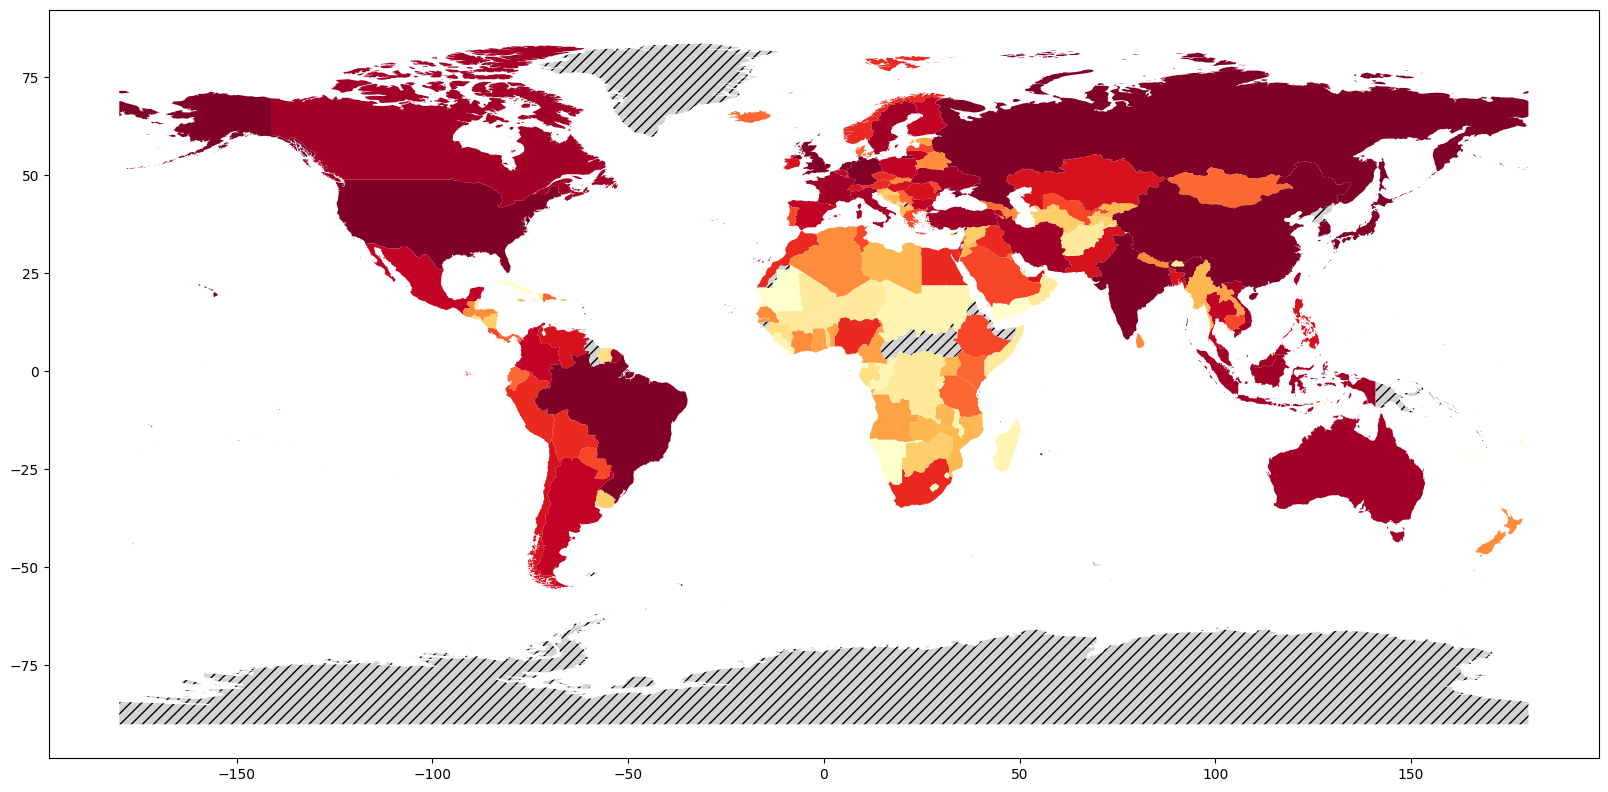

In [168]:
import geopandas

# Download geojson for map renedering
WORLD_GEOJSON_FILEPATH = 'data/ne_50m_admin_0_countries.geojson'

download_file_as('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/ca96624a/geojson/ne_50m_admin_0_countries.geojson', WORLD_GEOJSON_FILEPATH)

world = geopandas.read_file(WORLD_GEOJSON_FILEPATH)

# Calculate data per country
country_counts = df.groupby('country').size().reset_index(name='count')
world = world.merge(country_counts, how='left', left_on='ADM0_A3', right_on='country')

# Plot data on country
world.plot(column='count', cmap='YlOrRd', figsize=(20, 30), scheme="Quantiles", k=15, missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Missing values"})

### Top 10 IP Abuse Countries and Networks

In [169]:
# Extract top10 ip abuse countries
country_counts = df.groupby('country').size().reset_index(name='count')
top10_countries = country_counts.sort_values('count', ascending=False).head(10)
top10_countries['country'] = top10_countries['country'].apply(lambda country: str(pycountry.countries.get(alpha_3=country).name))

top10_countries

,country,count
173,United States,19152
31,China,15701
145,Singapore,5168
140,Russian Federation,4625
45,Germany,4257
88,"Korea, Republic of",3575
68,Hong Kong,2589
74,India,2582
58,United Kingdom,2523
123,Netherlands,2183


In [170]:
# Extract top10 ip abuse Networks
asn_counts = df.groupby('asn').size().reset_index(name='count')
top10_asns = asn_counts.sort_values('count', ascending=False).head(10)

top10_asns

,asn,count
763,AS14061,6131
3805,AS4134,5620
5177,AS8075,2801
3683,AS396982,2714
4024,AS45102,2520
1098,AS16509,2388
4163,AS4766,2294
3672,AS396190,2048
4714,AS57026,2048
4228,AS4837,1915


### Calculate Network Sizes

In [216]:
# Download ASN Dataset
IPINFO_ASN_FILEPATH = 'data/asn.csv.gz'

download_file_as(f"https://ipinfo.io/data/free/asn.csv.gz?token={os.environ.get('IPINFO_KEY')}", IPINFO_ASN_FILEPATH)

raw_asn_df = pd.read_csv(IPINFO_ASN_FILEPATH)

# Convert IP address columns to integers
raw_asn_df['start_ip'] = raw_asn_df['start_ip'].apply(ip_to_ipaddress)
raw_asn_df['end_ip'] = raw_asn_df['end_ip'].apply(ip_to_ipaddress)

# Add a column for IP version
raw_asn_df['ip_version'] = raw_asn_df['start_ip'].apply(ip_to_ipversion)

# Calculate the total number of IPs in each range
def calculate_ip_counts(row):
    summarized_ranges = ipaddress.summarize_address_range(row['start_ip'], row['end_ip'])
    total_ips = sum(network.num_addresses for network in summarized_ranges)
    return total_ips

# Calculate the number of IPs in each range
raw_asn_df['total_ips'] = raw_asn_df.apply(calculate_ip_counts, axis=1)

# Sum based on ASN (one ASN can have multiple IP ranges)
asn_df = raw_asn_df.groupby(['asn', 'name', 'domain', 'ip_version'])['total_ips'].sum().reset_index()

In [217]:
# Check for duplicates
asn_df[asn_df.duplicated(subset=['asn', 'ip_version'])]

,asn,name,domain,ip_version,total_ips


### Top 10 Networks by Size

In [218]:
total_ips_count = asn_df[asn_df['ip_version'] == 'IPv4']

total_ips_count.sort_values('total_ips', ascending=False).head(10)

,asn,name,domain,ip_version,total_ips
99488,AS749,DoD Network Information Center,mail.mil,IPv4,224801280
77080,AS4134,CHINANET-BACKBONE,chinatelecom.com.cn,IPv4,103575296
99238,AS7018,"AT&T Services, Inc.",att.com,IPv4,90457600
99790,AS7922,"Comcast Cable Communications, LLC",comcast.com,IPv4,69614336
99870,AS8075,Microsoft Corporation,microsoft.com,IPv4,59554304
83603,AS4837,CHINA UNICOM China169 Backbone,chinaunicom.cn,IPv4,57449472
17572,AS16509,"Amazon.com, Inc.",amazon.com,IPv4,47518720
82838,AS4766,Korea Telecom,kt.com,IPv4,46454016
18574,AS17676,SoftBank Corp.,softbank.jp,IPv4,43512832
99229,AS701,Verizon Business,verizonbusiness.com,IPv4,40398336


In [219]:
total_ips_count = asn_df[asn_df['ip_version'] == 'IPv6']

total_ips_count.sort_values('total_ips', ascending=False).head(10)

,asn,name,domain,ip_version,total_ips
99791,AS7922,"Comcast Cable Communications, LLC",comcast.com,IPv6,669949072294624359820762581827584
64110,AS3320,Deutsche Telekom AG,telekom3.de,IPv6,651734635481969819072888444026880
18575,AS17676,SoftBank Corp.,softbank.jp,IPv6,344880191424592661544696815812608
99388,AS7303,Telecom Argentina S.A.,telecom.com.ar,IPv6,325231607121055105821497916129280
40287,AS23910,China Next Generation Internet CERNET2,cernet.edu.cn,IPv6,324755845245078145041454872920064
62105,AS3269,Telecom Italia S.p.A.,telecomitalia.com,IPv6,324518557285204185627043544694784
1719,AS1221,Telstra Limited,telstra.com.au,IPv6,324518554867352546397785195282432
41055,AS24863,Link Egypt (Link.NET),orange.com,IPv6,324518553658426726783156020576256
72695,AS397165,EpicUp Holdings Inc,digitalworkspaces.com,IPv6,324518553658426726783156020576256
8282,AS137726,China Petroleum & Chemical Corporation,pcitc.com,IPv6,324518553658426726783156020576256


### Calculate Network IP Abuse Percentage

In [220]:
asn_abuse_df = df.groupby(['asn', 'ip_version']).size().reset_index(name='count')
asn_abuse_df = asn_abuse_df.merge(asn_df, how='left', on=['asn', 'ip_version'])

asn_abuse_df['percentage'] = (100 / asn_abuse_df['total_ips']) * asn_abuse_df['count']

### Top 10 Networks by IP Abuse Percentage

In [221]:
asn_abuse_df.sort_values('percentage', ascending=False).head(10)

,asn,ip_version,count,name,domain,total_ips,percentage
1805,AS211298,IPv4,504,INTERNET MEASUREMENT,internet-measurement.com,512,98.4375
1921,AS214961,IPv4,111,Stellar Group SAS,stellar-group.fr,256,43.359375
1968,AS215766,IPv4,103,Emanuel Hosting Ltd.,emanuelhosting.info,256,40.234375
3749,AS398722,IPv4,177,"Censys, Inc.",censys.io,512,34.570312
5359,AS9465,IPv4,85,AGOTOZ PTE. LTD.,agotoz.com,256,33.203125
1711,AS208843,IPv4,524,Alpha Strike Labs GmbH,alphastrike.io,2048,25.585938
4942,AS60729,IPv4,155,Stiftung Erneuerbare Freiheit,zwiebelfreunde.de,768,20.182292
1641,AS206813,IPv4,256,4830.org e. V.,4830.org,1280,20.0
3746,AS398705,IPv4,96,"Censys, Inc.",censys.io,512,18.75
1821,AS211680,IPv4,236,"NSEC - Sistemas Informaticos, S.A.",nsec.pt,1280,18.4375


### Top IPs with most Abuse List Entries

In [222]:
source_counts = df
source_counts['sources_count'] = source_counts['sources'].apply(len)
source_counts = source_counts.merge(asn_df, how='left', on=['asn', 'ip_version'])

source_counts[source_counts['sources_count']==source_counts['sources_count'].max()]

,ip,sources,ip_version,country,continent,asn,sources_count,name,domain,total_ips
8872,111.23.122.227,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,CHN,AS,AS56047,5,China Mobile communications corporation,chinamobile.com,783616
11759,115.153.87.2,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,CHN,AS,AS4134,5,CHINANET-BACKBONE,chinatelecom.com.cn,103575296
13656,118.123.105.92,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,CHN,AS,AS38283,5,CHINANET SiChuan Telecom Internet Data Center,chinatelecom.cn,271872
19053,128.14.209.26,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,USA,NA,AS21859,5,Zenlayer Inc,zenlayer.com,607488
19109,128.199.144.161,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,SGP,AS,AS14061,5,"DigitalOcean, LLC",digitalocean.com,2958848
...,...,...,...,...,...,...,...,...,...,...
81023,80.82.77.202,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,NLD,EU,AS202425,5,IP Volume inc,ipvolume.net,14592
81024,80.82.77.33,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,NLD,EU,AS202425,5,IP Volume inc,ipvolume.net,14592
83762,89.248.167.131,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,NLD,EU,AS202425,5,IP Volume inc,ipvolume.net,14592
83779,89.248.172.16,"[greensnow_co.txt, abuseipdb_30d_blocklist.txt...",IPv4,NLD,EU,AS202425,5,IP Volume inc,ipvolume.net,14592


## IP Abuse Score Calculation

In [271]:
ASN_WEIGHT = 0.2
NUM_LISTS = len(available_lists)

score_df = df

score_df = score_df.merge(asn_abuse_df, how='left', on='asn')
score_df['sources_len'] = score_df['sources'].apply(len)
score_df['score'] = ASN_WEIGHT*(score_df['percentage'] / 100) + ((1 - ASN_WEIGHT) * (score_df['sources_len']/NUM_LISTS))

In [272]:
print(f"Score between {score_df['score'].min():1.2f} and {score_df['score'].max():1.2f}")

Score between 0.16 and 0.87


In [273]:
def get_abuse_score(ip):
    try:
        info = ipinfo.get(ip)

        asn_abuse_score_df = asn_abuse_df[(asn_abuse_df['asn'] == info['asn']) & (asn_abuse_df['ip_version'] == ip_to_ipversion(ip))]
        if asn_abuse_score_df.empty:
            asn_abuse_score = 0
        else:
            asn_abuse_score = asn_abuse_score_df.squeeze()['percentage']
        ip_sources_len =  len(df[df['ip'] == ip_to_ipaddress(ip)].squeeze()['sources'])

        return ASN_WEIGHT*asn_abuse_score + ((1 - ASN_WEIGHT) * (ip_sources_len / NUM_LISTS))
    except ValueError:
        print(f"Failed to get abuse score for IP {ip}!")

In [274]:
def score_lookup_helper(ip):
    print(f"{ip} = {get_abuse_score(ip):1.4f}")

# Score lookup for known IPs
score_lookup_helper('1.1.1.1')
score_lookup_helper('8.8.8.8')

# Score lookup for abuser IPs
score_lookup_helper('95.214.27.253')
score_lookup_helper('61.177.172.172')

1.1.1.1 = 0.0000
8.8.8.8 = 0.0000
95.214.27.253 = 0.6400
61.177.172.172 = 0.6400


### Map of median IP Abuse Score

<Axes: >

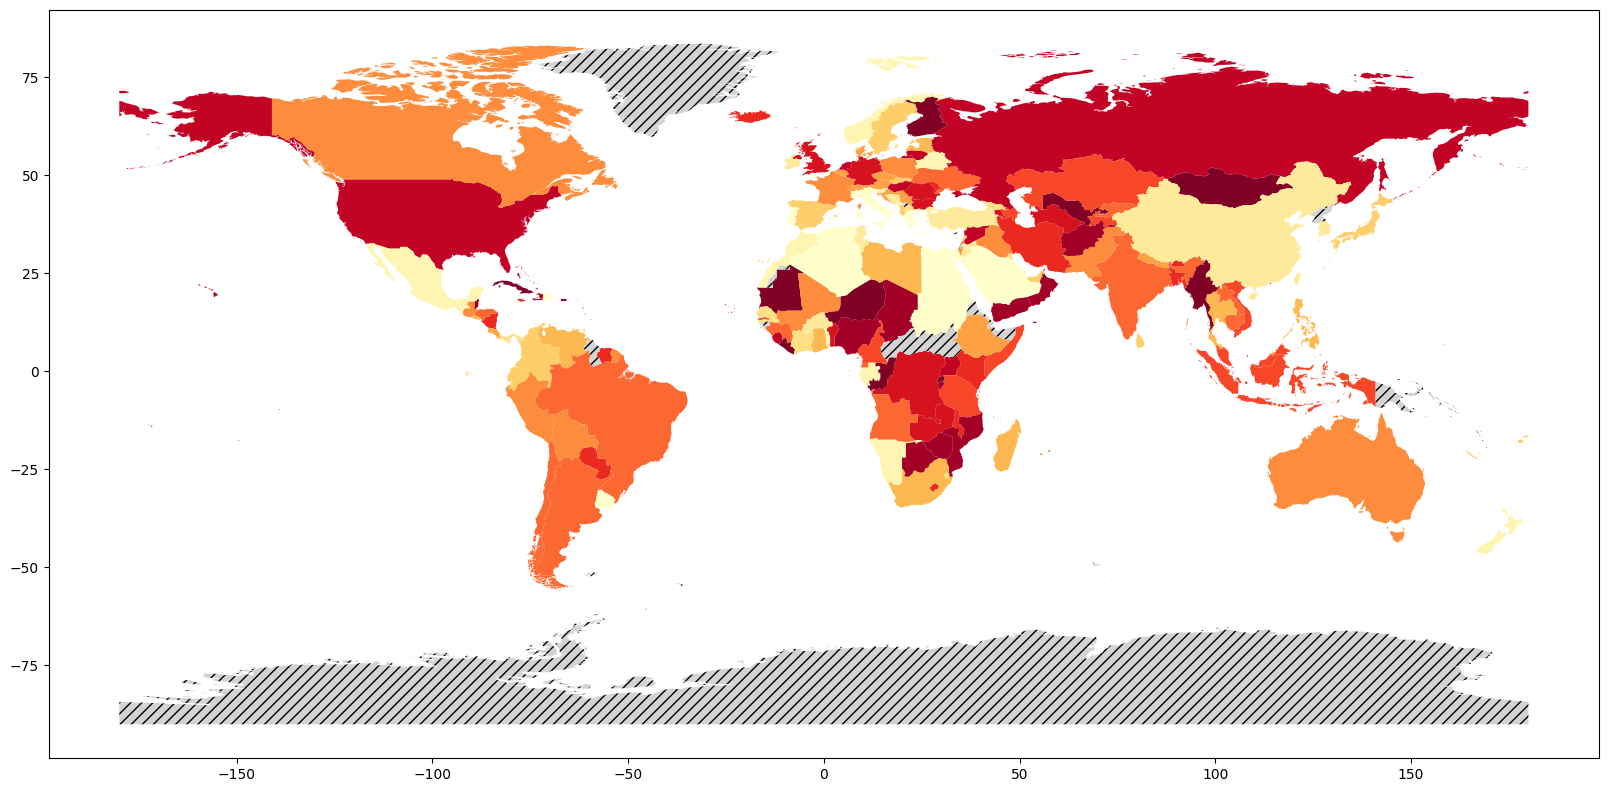

In [275]:
import geopandas

# Download geojson for map renedering
WORLD_GEOJSON_FILEPATH = 'data/ne_50m_admin_0_countries.geojson'

download_file_as('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/ca96624a/geojson/ne_50m_admin_0_countries.geojson', WORLD_GEOJSON_FILEPATH)

world = geopandas.read_file(WORLD_GEOJSON_FILEPATH)

# Calculate data per country
country_median_score = score_df.groupby('country')['score'].median()
world = world.merge(country_median_score, how='left', left_on='ADM0_A3', right_on='country')

# Plot data on country
world.plot(column='score', cmap='YlOrRd', figsize=(20, 30), scheme="Quantiles", k=15, missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Missing values"})

### Top 10 IP Abuse Score Median Countries

In [276]:
country_counts = score_df.groupby('country')['score'].median().reset_index(name='score_median')
top10_countries = country_counts.sort_values('score_median', ascending=False).head(10)
top10_countries['country'] = top10_countries['country'].apply(lambda country: str(pycountry.countries.get(alpha_3=country).name))

top10_countries

,country,score_median
94,Liechtenstein,0.640024
113,Mauritania,0.640008
40,Cuba,0.640001
120,Niger,0.480065
111,Mongolia,0.480063
54,Finland,0.480037
92,Liberia,0.400122
141,Rwanda,0.400034
35,Congo,0.400013
104,Maldives,0.400007
